# Notebook 2 - Explaining Speech Emotion Recognition - Part 1
##  XAI for Affective Computing with Counterfactuals (SoSe2024)

In this first part of our second Jupyter Notebook assignment, you will attempt to generate counterfactual explanations of a speech emotion recognition (SER) task using tabular data and a XGBoost classifier. 

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the Notebook 2 section of the **README** beforing starting this notebook for all installation instructions.

## Notebook Setup

In [2]:
%load_ext autoreload
%autoreload 2

##### Import necessary libraries

(see README for necessary package installations if you receive a `module not found` error.

In [3]:
from pathlib import Path

import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio
import IPython

## Counterfactuals with Tabular Audio Features

### Data and Model

#### Load the Data

First we need to load our datast.  For this task, we will be using the audio portion of the [Ravdess dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio).  

In this task, we provide you with preextracted features in the form of a pandas dataframe.  Tabular features were extracted with the [openSmile](https://audeering.github.io/opensmile-python/) package using the [Extended Geneva Minimalistic Acoustic Parameter
Set (EGeMAPS)](https://mediatum.ub.tum.de/doc/1523509/file.pdf). Please have a look at the paper for a detailed explanation of the different features.

The dataset has been split using actor numbers into a training and testing datasets to ensure there is no data leakage between training and testing the model.  

We are also providing 300 audio clips of the test dataset containing actors \[15,  8, 20, 11,  5\]

Below we load this dataset and display 5 random samples from the training set

In [4]:
LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# load dataframes from CSV
df_train = pd.read_csv('../data/ravdess/features/radvess_opensmile_train.csv')
df_test = pd.read_csv('../data/ravdess/features/radvess_opensmile_test.csv')

# update audio_paths to match new locations
audio_path = Path('../data/ravdess/audio_clips')
def update_paths(row):
    return str(audio_path / Path(row.path).name)
df_train.path = df_train.apply(update_paths, axis='columns')
df_test.path = df_test.apply(update_paths, axis='columns')

# get feature columns
feature_names = list(df_train.columns[6:])

df_train.sample(5)

,Unnamed: 0,actor,emotion,intensity,path,emotion_label,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
385,385,2,5,1,../data/ravdess/audio_clips/03-01-06-01-01-02-...,fear,42.999439,0.048128,41.698807,42.606998,...,0.115941,0.009895,0.013142,1.881720,1.089918,0.370000,0.476078,0.5225,0.498767,-37.441570
400,400,2,4,2,../data/ravdess/audio_clips/03-01-05-02-01-01-...,angry,41.345402,0.154382,37.281883,44.012127,...,0.074602,0.009917,0.039422,2.570694,1.041667,0.395000,0.235213,0.4340,0.480192,-27.439207
260,260,13,3,1,../data/ravdess/audio_clips/03-01-04-01-02-01-...,sad,24.288719,0.050945,23.058891,24.366669,...,0.005201,0.010197,0.004869,2.046784,1.186944,0.287500,0.140957,0.4260,0.461415,-50.128368
614,614,12,6,2,../data/ravdess/audio_clips/03-01-07-02-02-01-...,disgust,37.587688,0.128439,32.414112,36.653603,...,0.032043,0.005435,0.018217,1.909308,0.724638,0.553333,0.133000,0.6025,0.420795,-34.149673
1050,1230,10,3,1,../data/ravdess/audio_clips/03-01-04-01-01-02-...,sad,33.430145,0.065290,31.719952,33.195580,...,0.039922,0.003749,0.016117,2.601156,1.470588,0.230000,0.127122,0.3500,0.424892,-43.076347


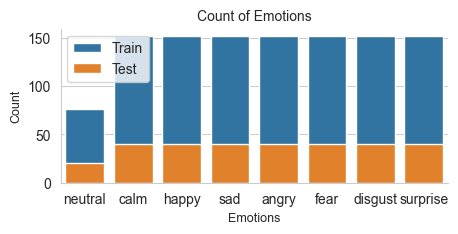

In [5]:
# Plot Label Distribution
plt.figure(figsize=(5,2))

sns.countplot(x= df_train.emotion_label, label='Train', order=LABELS)
sns.countplot(x= df_test.emotion_label, label='Test', order=LABELS)

plt.title('Count of Emotions', size=10)
plt.ylabel('Count', size=9)
plt.xlabel('Emotions', size=9)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.legend()

#### Train XGBoost Model

Now we train an XGBoost model to perform explanations.  The model should get $100\%$ on the training data.

In [6]:
random_state = 24

xgb = XGBClassifier(n_estimators=20, 
                    max_depth=15,
                    learning_rate=0.1, 
                    objective='binary:logistic',
                    random_state=random_state)

xgb.fit(df_train[feature_names], df_train['emotion'])
score = xgb.score(df_train[feature_names], df_train['emotion'])
print(f'Train Accuracy: {score*100:.2f}%')

Train Accuracy: 100.00%


#### Evaluate the model

Now let's evaluate the performance of the RDF Classifier on on the `X_aus` dataset. The accuracy should be around $45.67\%$, indicating significant overfitting. However, it is much better than random guessing at $12.5\%$

We should also generate the predictions of the model for the dataset, and store them in the dataframe

In [7]:
score = xgb.score(df_test[feature_names], df_test['emotion'])
print(f'Test Accuracy: {score*100:.2f}%')

# generate predictions for later user
df_test['emotion_pred'] = xgb.predict(df_test[feature_names])

Test Accuracy: 45.67%


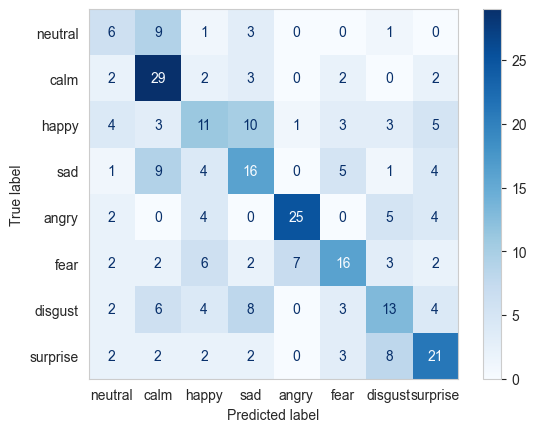

In [8]:
cm = confusion_matrix(df_test['emotion'], df_test['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

### Task 1: Generate Counterfactual Explanations using DiCE

In this part of the notebook, you will generate Counterfactual Explanations using the Python Library, [Diverse Counterfactual Explanations (DiCE)](http://interpret.ml/DiCE/). Make sure to read the documentation and getting started information.

#### Review the Dataset

First let's review some samples to select a few examples to select.  

Below you can load a random set of samples and then listen to the audio clips.  Make sure to note down the index value for sample that you would like to keep for analysis.  

(note: the audio display function doesn't work if your using PyCharm)

(note you can also filter by emotion if  you prefer. By filtering the data frame, for example: `df_test[df_test['emotion_label'] == 'happy']`

In [9]:
audio_samples = df_test.sample(5, random_state=0)
audio_samples

,Unnamed: 0,actor,emotion,intensity,path,emotion_label,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_pred
208,1348,8,6,1,../data/ravdess/audio_clips/03-01-07-01-02-01-...,disgust,33.104279,0.117677,31.524147,34.266598,...,0.008169,0.008913,2.295918,0.775194,0.466667,0.126842,0.600000,0.430987,-46.100063,1
188,1328,8,2,2,../data/ravdess/audio_clips/03-01-03-02-01-02-...,happy,36.570362,0.091957,32.891212,36.405704,...,0.007689,0.023717,1.799486,0.781250,0.500000,0.341272,0.567500,0.493071,-35.292259,2
12,972,5,5,1,../data/ravdess/audio_clips/03-01-06-01-01-02-...,fear,29.906525,0.100353,28.000912,29.711512,...,0.008507,0.009418,2.083333,1.510574,0.198000,0.075472,0.368333,0.422233,-45.976295,5
221,1361,8,6,2,../data/ravdess/audio_clips/03-01-07-02-01-01-...,disgust,35.314842,0.145752,32.633179,35.087833,...,0.007306,0.017660,2.216749,1.496259,0.200000,0.157586,0.382857,0.469672,-42.587292,3
239,1379,8,1,1,../data/ravdess/audio_clips/03-01-02-01-02-02-...,calm,34.319344,0.075051,33.949970,34.532299,...,0.006600,0.009725,2.890173,0.879765,0.376667,0.194308,0.552500,0.479290,-51.196003,1


In [10]:
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 208 - Emotion: disgust | Prediction: calm
../data/ravdess/audio_clips/03-01-07-01-02-01-08.wav


Index: 188 - Emotion: happy | Prediction: happy
../data/ravdess/audio_clips/03-01-03-02-01-02-08.wav


Index: 12 - Emotion: fear | Prediction: fear
../data/ravdess/audio_clips/03-01-06-01-01-02-05.wav


Index: 221 - Emotion: disgust | Prediction: sad
../data/ravdess/audio_clips/03-01-07-02-01-01-08.wav


Index: 239 - Emotion: calm | Prediction: calm
../data/ravdess/audio_clips/03-01-02-01-02-02-08.wav


#### Task 1.0: Select Your Samples
- After reviewing the samples above, select four that you would like to generate explanations for.
- For each sample, also choose the desired class index that you would like to generate counterfactuals for
    - make sure to think about why we need a "desired class" for counterfactuals and what is important when selecting one

In [11]:
#### Enter the Indexes Here ### 
###############################
# you will use these arrays later in the task
idxs = []
desired_classes = []

#### Task 1.1: Setup the DiCE Explainer and Generate Explanations
Now it's time to generate the counterfactual explanations.

In [12]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

pd.set_option('display.max_columns', None) # so that Jupyter doesn't truncate columns of dataframe

##### Task 1.1.1 Setup a DiCE explainer instance

See the [intro to DiCE](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html) for details on working with this library.

Note: DiCE requires requires pandas dataframes for creating explainers and explanations. 
- for setting up the explainer you can use the following to create a dataframe containing only features and the label from the training data
    - `df_train[feature_names+['emotion']`
- for generating a dataframe of a single instance to explain, you can use the following code:
    - `df_test[40:41]` where 40 is the index of instance to explan

In [13]:
##### YOUR CODE GOES HERE #####
###############################

##### Task 1.1.2: Use the Explainer to Generate Counterfactual Explanations

Generate counterfacutal explanations for each of your selected samples. 

Finding counterfactuals for this task, is sometimes challenging for the model. Therefore, you may get messages indicating that no counterfactuals were found. In this case, you change your "desired_class" or choose another sample

In [14]:
##### YOUR CODE GOES HERE #####
###############################

##### Task 1.1.3: Visualize Counterfactuals

Now visualize the counterfactuals as Pandas dataframes. 

It would also be helpful to include the original audio clip with the explanation, as well as to print the label names for the ground truth, the prediction, and the desired outcome.  

You can use the following to load multiple audio clips in one jupyter cell:
```python
IPython.display.display(IPython.display.Audio(sample.path))
```

In [15]:
##### YOUR CODE GOES HERE #####
###############################


#### Task 1.2: Describe your observations

1. What is your first impression of counterfactuals for this dataset and task?
2. Would another task or dataset be more suited for this approach?
3. Which features are most important for the detection of the specific emotions in your selections? Can you find any patterns?  Do the counterfactuals make sense according to your intuition of the contrastive expression class you're using?
2. The `generate_counterfactuals` method has a parameter `features_to_vary` so that we can restrict which features are perturbed in CF generation.  Are there any features that shouldn't be perturbed for our task of emotion detection? Why or why not? Additionally, should we set `permitted_range` parameter to limit the ranges of our continous features?


Answer here...

### Task 2: Generate Feature Attribution Scores from Counterfactuals

DiCE can also generate [local and global feature attribution scores](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html#Generating-feature-attributions-(local-and-global)-using-DiCE) based on the identified counterfactuals.  In this task, we will do just that.  

In [16]:
# function for plotting importance dictionaries provided by DiCE
def plot_importance_dict(importance_dict, top_n):
    keys = list(importance_dict.keys())[:top_n]
    vals = [float(importance_dict[k]) for k in keys][:top_n]
    sns.barplot(x=keys, y=vals)
    plt.xticks(rotation=90)

#### Task 2.1 Generate and Plot Local Importance Scores

Using your previously defined DiCE explainer, generate and plot (with the help of the function above) local importance scores your your data instances.

Again, it is helpful to also include the original audio sample and feature values, as well as to print the label names for the ground truth, the prediction, and the desired outcome.   

In [17]:
##### YOUR CODE GOES HERE #####
###############################
from IPython.display import display # (use display to display a dataframe)

#### Task 2.2 Generate and Plot Global Importance Scores

Using your previously defined DiCE explainer, generate and plot global importance using the entire XAI dataset.

In [18]:
##### YOUR CODE GOES HERE #####
###############################

#### Task 2.3 Describe your findings


1. Based on the DiCE documentation, how does DiCE calculate feature importance from counterfactuals?
2. Do the plots match your expectations for each emotion or do they lead to any interesting insights regarding AUs or facial expression detection?

Write your answer here...